# AnoGAN
- 2020.08.11 : Genrator 학습 수 ... 4

# 개발일지
- 2020.08.14 : 분율 추출 구현
- 2020.08.15 : 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티티늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [4]:
latent_size = 100 # z벡터의 잠재공간(latent space)의 크기
workers = 4 # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 1e-5

# Data and Device

In [5]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
data_root = "../../../OhSeHyeon/source/dataset/aug_train"

data_set = dataset.ImageFolder(root = data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 920
device : cuda:0


# MODEL

In [6]:
# Generative Adversarial Networks Model

# === Generator 모델 ===
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def G_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.G_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *G_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *G_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *G_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *G_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.G_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1 , 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.G_gen_distribution(input)
        fake_img = self.G_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, BN=True):
            if BN:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            return block
        
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, BN=False),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, BN=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, BN=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, BN=True)
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature

# Loss & Optim

In [7]:
# G and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,G 네트워크 모델 객체 선언
D = Discriminator().to(device)
G = Generator().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
G.apply(weights_init)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 G로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 G에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(G)

def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

---

# Train DCGAN

In [8]:
img_list = []
G_losses = []
D_losses = []
iters = 0

def train(epoch, learning_G_per_D):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train Discriminator
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = G(z)
        fake_classification, _ = D(fake_img) # output = D(G(z))
        fake_loss = criterion(fake_classification, fake_labels) # D(G(z))=0일 때의 loss
        fake_score = fake_classification
        D_G_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss 
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(G(z))=0이어야 D가 최적

        
        # Train Generater
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_G_per_D):
            fake_img = G(z)
            fake_classification, _ = D(fake_img)  # output : D(G(z))
            D_G_z2 = fake_classification.mean().item()
            G_loss = criterion(fake_classification, real_labels) # D(G(z))=1일 때의 loss=log(D(G(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            G_loss.backward()
            G_optimizer.step() # D(G(z))=1 이어야 G가 최적
            # ==> D(G(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / G_loss : %.4f\n- D(x) : %.4f / D(G(z1)) : %.4f / D(G(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     G_loss.item(),D_x,D_G_z1,D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = G(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(G.state_dict(), 'G.ckpt')
#torch.save(D.state_dict(), 'D.ckpt')

In [9]:
for epoch in range(epochs):
    train(epoch, learning_G_per_D = 1)

/home/piai/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/14]
- D_loss : 1.3930 / G_loss : 0.6949
- D(x) : 0.4963 / D(G(z1)) : 0.4995 / D(G(z2)) : 0.4992
[1/100][1/14]
- D_loss : 1.3911 / G_loss : 0.6955
- D(x) : 0.4968 / D(G(z1)) : 0.4992 / D(G(z2)) : 0.4988
[1/100][2/14]
- D_loss : 1.3903 / G_loss : 0.6951
- D(x) : 0.4974 / D(G(z1)) : 0.4994 / D(G(z2)) : 0.4990
[1/100][3/14]
- D_loss : 1.3898 / G_loss : 0.6951
- D(x) : 0.4977 / D(G(z1)) : 0.4994 / D(G(z2)) : 0.4990
[1/100][4/14]
- D_loss : 1.3873 / G_loss : 0.6942
- D(x) : 0.4993 / D(G(z1)) : 0.4998 / D(G(z2)) : 0.4995
[1/100][5/14]
- D_loss : 1.3836 / G_loss : 0.6959
- D(x) : 0.5004 / D(G(z1)) : 0.4990 / D(G(z2)) : 0.4987
[1/100][6/14]
- D_loss : 1.3836 / G_loss : 0.6959
- D(x) : 0.5004 / D(G(z1)) : 0.4990 / D(G(z2)) : 0.4986
[1/100][7/14]
- D_loss : 1.3834 / G_loss : 0.6946
- D(x) : 0.5011 / D(G(z1)) : 0.4996 / D(G(z2)) : 0.4993
[1/100][8/14]
- D_loss : 1.3802 / G_loss : 0.6948
- D(x) : 0.5026 / D(G(z1)) : 0.4995 / D(G(z2)) : 0.4992
[1/100][9/14]
- D_loss : 1.3796 / G_loss : 0.6

[6/100][8/14]
- D_loss : 1.2211 / G_loss : 0.7605
- D(x) : 0.5565 / D(G(z1)) : 0.4693 / D(G(z2)) : 0.4674
[6/100][9/14]
- D_loss : 1.2242 / G_loss : 0.7637
- D(x) : 0.5529 / D(G(z1)) : 0.4678 / D(G(z2)) : 0.4659
[6/100][10/14]
- D_loss : 1.2202 / G_loss : 0.7659
- D(x) : 0.5542 / D(G(z1)) : 0.4668 / D(G(z2)) : 0.4649
[6/100][11/14]
- D_loss : 1.2056 / G_loss : 0.7679
- D(x) : 0.5616 / D(G(z1)) : 0.4659 / D(G(z2)) : 0.4640
[6/100][12/14]
- D_loss : 1.2047 / G_loss : 0.7717
- D(x) : 0.5602 / D(G(z1)) : 0.4643 / D(G(z2)) : 0.4622
[6/100][13/14]
- D_loss : 1.2007 / G_loss : 0.7752
- D(x) : 0.5610 / D(G(z1)) : 0.4627 / D(G(z2)) : 0.4606
[7/100][0/14]
- D_loss : 1.1987 / G_loss : 0.7789
- D(x) : 0.5602 / D(G(z1)) : 0.4610 / D(G(z2)) : 0.4589
[7/100][1/14]
- D_loss : 1.1920 / G_loss : 0.7819
- D(x) : 0.5628 / D(G(z1)) : 0.4597 / D(G(z2)) : 0.4576
[7/100][2/14]
- D_loss : 1.1846 / G_loss : 0.7851
- D(x) : 0.5653 / D(G(z1)) : 0.4583 / D(G(z2)) : 0.4561
[7/100][3/14]
- D_loss : 1.1887 / G_loss :

[12/100][4/14]
- D_loss : 0.8125 / G_loss : 1.1370
- D(x) : 0.6561 / D(G(z1)) : 0.3227 / D(G(z2)) : 0.3208
[12/100][5/14]
- D_loss : 0.8066 / G_loss : 1.1415
- D(x) : 0.6584 / D(G(z1)) : 0.3213 / D(G(z2)) : 0.3193
[12/100][6/14]
- D_loss : 0.8169 / G_loss : 1.1457
- D(x) : 0.6508 / D(G(z1)) : 0.3199 / D(G(z2)) : 0.3180
[12/100][7/14]
- D_loss : 0.7951 / G_loss : 1.1505
- D(x) : 0.6631 / D(G(z1)) : 0.3184 / D(G(z2)) : 0.3165
[12/100][8/14]
- D_loss : 0.7965 / G_loss : 1.1545
- D(x) : 0.6611 / D(G(z1)) : 0.3171 / D(G(z2)) : 0.3152
[12/100][9/14]
- D_loss : 0.7909 / G_loss : 1.1596
- D(x) : 0.6632 / D(G(z1)) : 0.3155 / D(G(z2)) : 0.3136
[12/100][10/14]
- D_loss : 0.7845 / G_loss : 1.1645
- D(x) : 0.6660 / D(G(z1)) : 0.3139 / D(G(z2)) : 0.3121
[12/100][11/14]
- D_loss : 0.7895 / G_loss : 1.1698
- D(x) : 0.6612 / D(G(z1)) : 0.3122 / D(G(z2)) : 0.3104
[12/100][12/14]
- D_loss : 0.7649 / G_loss : 1.1733
- D(x) : 0.6763 / D(G(z1)) : 0.3112 / D(G(z2)) : 0.3094
[12/100][13/14]
- D_loss : 0.7805 

[17/100][12/14]
- D_loss : 0.5619 / G_loss : 1.4391
- D(x) : 0.7487 / D(G(z1)) : 0.2382 / D(G(z2)) : 0.2371
[17/100][13/14]
- D_loss : 0.5557 / G_loss : 1.4429
- D(x) : 0.7525 / D(G(z1)) : 0.2373 / D(G(z2)) : 0.2362
[18/100][0/14]
- D_loss : 0.5706 / G_loss : 1.4455
- D(x) : 0.7409 / D(G(z1)) : 0.2367 / D(G(z2)) : 0.2356
[18/100][1/14]
- D_loss : 0.5642 / G_loss : 1.4490
- D(x) : 0.7450 / D(G(z1)) : 0.2359 / D(G(z2)) : 0.2348
[18/100][2/14]
- D_loss : 0.5547 / G_loss : 1.4526
- D(x) : 0.7510 / D(G(z1)) : 0.2350 / D(G(z2)) : 0.2340
[18/100][3/14]
- D_loss : 0.5559 / G_loss : 1.4561
- D(x) : 0.7493 / D(G(z1)) : 0.2342 / D(G(z2)) : 0.2332
[18/100][4/14]
- D_loss : 0.5627 / G_loss : 1.4588
- D(x) : 0.7438 / D(G(z1)) : 0.2336 / D(G(z2)) : 0.2325
[18/100][5/14]
- D_loss : 0.5594 / G_loss : 1.4623
- D(x) : 0.7453 / D(G(z1)) : 0.2327 / D(G(z2)) : 0.2317
[18/100][6/14]
- D_loss : 0.5517 / G_loss : 1.4649
- D(x) : 0.7505 / D(G(z1)) : 0.2321 / D(G(z2)) : 0.2311
[18/100][7/14]
- D_loss : 0.5397 / 

[23/100][8/14]
- D_loss : 0.4233 / G_loss : 1.6826
- D(x) : 0.8053 / D(G(z1)) : 0.1866 / D(G(z2)) : 0.1859
[23/100][9/14]
- D_loss : 0.4247 / G_loss : 1.6859
- D(x) : 0.8035 / D(G(z1)) : 0.1860 / D(G(z2)) : 0.1853
[23/100][10/14]
- D_loss : 0.4230 / G_loss : 1.6877
- D(x) : 0.8046 / D(G(z1)) : 0.1857 / D(G(z2)) : 0.1850
[23/100][11/14]
- D_loss : 0.4251 / G_loss : 1.6909
- D(x) : 0.8023 / D(G(z1)) : 0.1851 / D(G(z2)) : 0.1844
[23/100][12/14]
- D_loss : 0.4207 / G_loss : 1.6933
- D(x) : 0.8054 / D(G(z1)) : 0.1846 / D(G(z2)) : 0.1839
[23/100][13/14]
- D_loss : 0.4223 / G_loss : 1.6966
- D(x) : 0.8036 / D(G(z1)) : 0.1840 / D(G(z2)) : 0.1833
[24/100][0/14]
- D_loss : 0.4244 / G_loss : 1.6992
- D(x) : 0.8014 / D(G(z1)) : 0.1835 / D(G(z2)) : 0.1828
[24/100][1/14]
- D_loss : 0.4173 / G_loss : 1.7020
- D(x) : 0.8066 / D(G(z1)) : 0.1830 / D(G(z2)) : 0.1823
[24/100][2/14]
- D_loss : 0.4147 / G_loss : 1.7053
- D(x) : 0.8081 / D(G(z1)) : 0.1824 / D(G(z2)) : 0.1817
[24/100][3/14]
- D_loss : 0.4098 

[29/100][4/14]
- D_loss : 0.3365 / G_loss : 1.8990
- D(x) : 0.8407 / D(G(z1)) : 0.1503 / D(G(z2)) : 0.1497
[29/100][5/14]
- D_loss : 0.3408 / G_loss : 1.9019
- D(x) : 0.8367 / D(G(z1)) : 0.1498 / D(G(z2)) : 0.1493
[29/100][6/14]
- D_loss : 0.3315 / G_loss : 1.9043
- D(x) : 0.8441 / D(G(z1)) : 0.1495 / D(G(z2)) : 0.1489
[29/100][7/14]
- D_loss : 0.3293 / G_loss : 1.9068
- D(x) : 0.8456 / D(G(z1)) : 0.1491 / D(G(z2)) : 0.1486
[29/100][8/14]
- D_loss : 0.3293 / G_loss : 1.9096
- D(x) : 0.8452 / D(G(z1)) : 0.1487 / D(G(z2)) : 0.1481
[29/100][9/14]
- D_loss : 0.3333 / G_loss : 1.9122
- D(x) : 0.8414 / D(G(z1)) : 0.1483 / D(G(z2)) : 0.1478
[29/100][10/14]
- D_loss : 0.3251 / G_loss : 1.9156
- D(x) : 0.8478 / D(G(z1)) : 0.1478 / D(G(z2)) : 0.1473
[29/100][11/14]
- D_loss : 0.3327 / G_loss : 1.9167
- D(x) : 0.8413 / D(G(z1)) : 0.1476 / D(G(z2)) : 0.1471
[29/100][12/14]
- D_loss : 0.3267 / G_loss : 1.9191
- D(x) : 0.8460 / D(G(z1)) : 0.1473 / D(G(z2)) : 0.1467
[29/100][13/14]
- D_loss : 0.3289 

[35/100][0/14]
- D_loss : 0.2694 / G_loss : 2.0920
- D(x) : 0.8719 / D(G(z1)) : 0.1239 / D(G(z2)) : 0.1234
[35/100][1/14]
- D_loss : 0.2686 / G_loss : 2.0937
- D(x) : 0.8724 / D(G(z1)) : 0.1237 / D(G(z2)) : 0.1232
[35/100][2/14]
- D_loss : 0.2730 / G_loss : 2.0954
- D(x) : 0.8684 / D(G(z1)) : 0.1235 / D(G(z2)) : 0.1230
[35/100][3/14]
- D_loss : 0.2684 / G_loss : 2.0977
- D(x) : 0.8721 / D(G(z1)) : 0.1232 / D(G(z2)) : 0.1227
[35/100][4/14]
- D_loss : 0.2673 / G_loss : 2.1001
- D(x) : 0.8727 / D(G(z1)) : 0.1229 / D(G(z2)) : 0.1224
[35/100][5/14]
- D_loss : 0.2649 / G_loss : 2.1031
- D(x) : 0.8745 / D(G(z1)) : 0.1225 / D(G(z2)) : 0.1221
[35/100][6/14]
- D_loss : 0.2668 / G_loss : 2.1043
- D(x) : 0.8727 / D(G(z1)) : 0.1224 / D(G(z2)) : 0.1219
[35/100][7/14]
- D_loss : 0.2667 / G_loss : 2.1074
- D(x) : 0.8724 / D(G(z1)) : 0.1220 / D(G(z2)) : 0.1216
[35/100][8/14]
- D_loss : 0.2645 / G_loss : 2.1101
- D(x) : 0.8740 / D(G(z1)) : 0.1217 / D(G(z2)) : 0.1212
[35/100][9/14]
- D_loss : 0.2648 / G_

[40/100][8/14]
- D_loss : 0.2287 / G_loss : 2.2574
- D(x) : 0.8890 / D(G(z1)) : 0.1051 / D(G(z2)) : 0.1046
[40/100][9/14]
- D_loss : 0.2295 / G_loss : 2.2593
- D(x) : 0.8881 / D(G(z1)) : 0.1049 / D(G(z2)) : 0.1044
[40/100][10/14]
- D_loss : 0.2243 / G_loss : 2.2610
- D(x) : 0.8925 / D(G(z1)) : 0.1047 / D(G(z2)) : 0.1042
[40/100][11/14]
- D_loss : 0.2224 / G_loss : 2.2639
- D(x) : 0.8939 / D(G(z1)) : 0.1044 / D(G(z2)) : 0.1040
[40/100][12/14]
- D_loss : 0.2252 / G_loss : 2.2667
- D(x) : 0.8912 / D(G(z1)) : 0.1041 / D(G(z2)) : 0.1037
[40/100][13/14]
- D_loss : 0.2199 / G_loss : 2.2695
- D(x) : 0.8957 / D(G(z1)) : 0.1039 / D(G(z2)) : 0.1034
[41/100][0/14]
- D_loss : 0.2213 / G_loss : 2.2718
- D(x) : 0.8942 / D(G(z1)) : 0.1036 / D(G(z2)) : 0.1031
[41/100][1/14]
- D_loss : 0.2208 / G_loss : 2.2742
- D(x) : 0.8943 / D(G(z1)) : 0.1034 / D(G(z2)) : 0.1029
[41/100][2/14]
- D_loss : 0.2219 / G_loss : 2.2755
- D(x) : 0.8932 / D(G(z1)) : 0.1032 / D(G(z2)) : 0.1027
[41/100][3/14]
- D_loss : 0.2186 

[46/100][4/14]
- D_loss : 0.1862 / G_loss : 2.4373
- D(x) : 0.9100 / D(G(z1)) : 0.0878 / D(G(z2)) : 0.0874
[46/100][5/14]
- D_loss : 0.1863 / G_loss : 2.4399
- D(x) : 0.9097 / D(G(z1)) : 0.0875 / D(G(z2)) : 0.0872
[46/100][6/14]
- D_loss : 0.1880 / G_loss : 2.4406
- D(x) : 0.9081 / D(G(z1)) : 0.0875 / D(G(z2)) : 0.0871
[46/100][7/14]
- D_loss : 0.1851 / G_loss : 2.4427
- D(x) : 0.9106 / D(G(z1)) : 0.0873 / D(G(z2)) : 0.0869
[46/100][8/14]
- D_loss : 0.1875 / G_loss : 2.4449
- D(x) : 0.9082 / D(G(z1)) : 0.0871 / D(G(z2)) : 0.0867
[46/100][9/14]
- D_loss : 0.1835 / G_loss : 2.4460
- D(x) : 0.9117 / D(G(z1)) : 0.0870 / D(G(z2)) : 0.0866
[46/100][10/14]
- D_loss : 0.1854 / G_loss : 2.4491
- D(x) : 0.9097 / D(G(z1)) : 0.0867 / D(G(z2)) : 0.0864
[46/100][11/14]
- D_loss : 0.1848 / G_loss : 2.4494
- D(x) : 0.9102 / D(G(z1)) : 0.0867 / D(G(z2)) : 0.0863
[46/100][12/14]
- D_loss : 0.1833 / G_loss : 2.4519
- D(x) : 0.9114 / D(G(z1)) : 0.0865 / D(G(z2)) : 0.0861
[46/100][13/14]
- D_loss : 0.1859 

[52/100][0/14]
- D_loss : 0.1610 / G_loss : 2.5847
- D(x) : 0.9212 / D(G(z1)) : 0.0758 / D(G(z2)) : 0.0754
[52/100][1/14]
- D_loss : 0.1589 / G_loss : 2.5846
- D(x) : 0.9232 / D(G(z1)) : 0.0759 / D(G(z2)) : 0.0754
[52/100][2/14]
- D_loss : 0.1595 / G_loss : 2.5888
- D(x) : 0.9222 / D(G(z1)) : 0.0755 / D(G(z2)) : 0.0751
[52/100][3/14]
- D_loss : 0.1584 / G_loss : 2.5904
- D(x) : 0.9231 / D(G(z1)) : 0.0754 / D(G(z2)) : 0.0750
[52/100][4/14]
- D_loss : 0.1586 / G_loss : 2.5921
- D(x) : 0.9227 / D(G(z1)) : 0.0752 / D(G(z2)) : 0.0749
[52/100][5/14]
- D_loss : 0.1577 / G_loss : 2.5936
- D(x) : 0.9235 / D(G(z1)) : 0.0751 / D(G(z2)) : 0.0748
[52/100][6/14]
- D_loss : 0.1590 / G_loss : 2.5975
- D(x) : 0.9220 / D(G(z1)) : 0.0748 / D(G(z2)) : 0.0745
[52/100][7/14]
- D_loss : 0.1599 / G_loss : 2.5983
- D(x) : 0.9212 / D(G(z1)) : 0.0748 / D(G(z2)) : 0.0744
[52/100][8/14]
- D_loss : 0.1622 / G_loss : 2.6011
- D(x) : 0.9188 / D(G(z1)) : 0.0745 / D(G(z2)) : 0.0742
[52/100][9/14]
- D_loss : 0.1562 / G_

[57/100][8/14]
- D_loss : 0.1389 / G_loss : 2.7463
- D(x) : 0.9302 / D(G(z1)) : 0.0644 / D(G(z2)) : 0.0642
[57/100][9/14]
- D_loss : 0.1380 / G_loss : 2.7445
- D(x) : 0.9312 / D(G(z1)) : 0.0645 / D(G(z2)) : 0.0643
[57/100][10/14]
- D_loss : 0.1361 / G_loss : 2.7483
- D(x) : 0.9327 / D(G(z1)) : 0.0643 / D(G(z2)) : 0.0641
[57/100][11/14]
- D_loss : 0.1362 / G_loss : 2.7493
- D(x) : 0.9326 / D(G(z1)) : 0.0643 / D(G(z2)) : 0.0640
[57/100][12/14]
- D_loss : 0.1351 / G_loss : 2.7530
- D(x) : 0.9334 / D(G(z1)) : 0.0640 / D(G(z2)) : 0.0638
[57/100][13/14]
- D_loss : 0.1337 / G_loss : 2.7564
- D(x) : 0.9345 / D(G(z1)) : 0.0638 / D(G(z2)) : 0.0635
[58/100][0/14]
- D_loss : 0.1390 / G_loss : 2.7573
- D(x) : 0.9295 / D(G(z1)) : 0.0637 / D(G(z2)) : 0.0635
[58/100][1/14]
- D_loss : 0.1337 / G_loss : 2.7590
- D(x) : 0.9343 / D(G(z1)) : 0.0637 / D(G(z2)) : 0.0634
[58/100][2/14]
- D_loss : 0.1349 / G_loss : 2.7601
- D(x) : 0.9332 / D(G(z1)) : 0.0636 / D(G(z2)) : 0.0633
[58/100][3/14]
- D_loss : 0.1337 

[63/100][4/14]
- D_loss : 0.1171 / G_loss : 2.8675
- D(x) : 0.9434 / D(G(z1)) : 0.0571 / D(G(z2)) : 0.0569
[63/100][5/14]
- D_loss : 0.1189 / G_loss : 2.8680
- D(x) : 0.9417 / D(G(z1)) : 0.0571 / D(G(z2)) : 0.0568
[63/100][6/14]
- D_loss : 0.1206 / G_loss : 2.8681
- D(x) : 0.9400 / D(G(z1)) : 0.0570 / D(G(z2)) : 0.0568
[63/100][7/14]
- D_loss : 0.1205 / G_loss : 2.8705
- D(x) : 0.9400 / D(G(z1)) : 0.0569 / D(G(z2)) : 0.0567
[63/100][8/14]
- D_loss : 0.1182 / G_loss : 2.8703
- D(x) : 0.9422 / D(G(z1)) : 0.0570 / D(G(z2)) : 0.0567
[63/100][9/14]
- D_loss : 0.1187 / G_loss : 2.8726
- D(x) : 0.9416 / D(G(z1)) : 0.0568 / D(G(z2)) : 0.0566
[63/100][10/14]
- D_loss : 0.1206 / G_loss : 2.8724
- D(x) : 0.9398 / D(G(z1)) : 0.0568 / D(G(z2)) : 0.0566
[63/100][11/14]
- D_loss : 0.1235 / G_loss : 2.8715
- D(x) : 0.9372 / D(G(z1)) : 0.0568 / D(G(z2)) : 0.0566
[63/100][12/14]
- D_loss : 0.1174 / G_loss : 2.8725
- D(x) : 0.9428 / D(G(z1)) : 0.0568 / D(G(z2)) : 0.0566
[63/100][13/14]
- D_loss : 0.1158 

[68/100][11/14]
- D_loss : 0.1027 / G_loss : 3.0021
- D(x) : 0.9499 / D(G(z1)) : 0.0500 / D(G(z2)) : 0.0497
[68/100][12/14]
- D_loss : 0.1035 / G_loss : 3.0037
- D(x) : 0.9490 / D(G(z1)) : 0.0499 / D(G(z2)) : 0.0496
[68/100][13/14]
- D_loss : 0.1024 / G_loss : 3.0068
- D(x) : 0.9498 / D(G(z1)) : 0.0497 / D(G(z2)) : 0.0495
[69/100][0/14]
- D_loss : 0.1016 / G_loss : 3.0101
- D(x) : 0.9505 / D(G(z1)) : 0.0495 / D(G(z2)) : 0.0493
[69/100][1/14]
- D_loss : 0.1039 / G_loss : 3.0106
- D(x) : 0.9483 / D(G(z1)) : 0.0495 / D(G(z2)) : 0.0493
[69/100][2/14]
- D_loss : 0.1032 / G_loss : 3.0126
- D(x) : 0.9488 / D(G(z1)) : 0.0494 / D(G(z2)) : 0.0492
[69/100][3/14]
- D_loss : 0.1034 / G_loss : 3.0137
- D(x) : 0.9486 / D(G(z1)) : 0.0493 / D(G(z2)) : 0.0491
[69/100][4/14]
- D_loss : 0.1014 / G_loss : 3.0156
- D(x) : 0.9503 / D(G(z1)) : 0.0492 / D(G(z2)) : 0.0490
[69/100][5/14]
- D_loss : 0.1036 / G_loss : 3.0156
- D(x) : 0.9483 / D(G(z1)) : 0.0492 / D(G(z2)) : 0.0490
[69/100][6/14]
- D_loss : 0.1013 /

[74/100][4/14]
- D_loss : 0.0889 / G_loss : 3.1420
- D(x) : 0.9563 / D(G(z1)) : 0.0433 / D(G(z2)) : 0.0432
[74/100][5/14]
- D_loss : 0.0901 / G_loss : 3.1441
- D(x) : 0.9552 / D(G(z1)) : 0.0433 / D(G(z2)) : 0.0431
[74/100][6/14]
- D_loss : 0.0891 / G_loss : 3.1452
- D(x) : 0.9561 / D(G(z1)) : 0.0432 / D(G(z2)) : 0.0431
[74/100][7/14]
- D_loss : 0.0893 / G_loss : 3.1470
- D(x) : 0.9558 / D(G(z1)) : 0.0431 / D(G(z2)) : 0.0430
[74/100][8/14]
- D_loss : 0.0887 / G_loss : 3.1479
- D(x) : 0.9563 / D(G(z1)) : 0.0431 / D(G(z2)) : 0.0430
[74/100][9/14]
- D_loss : 0.0893 / G_loss : 3.1511
- D(x) : 0.9557 / D(G(z1)) : 0.0430 / D(G(z2)) : 0.0428
[74/100][10/14]
- D_loss : 0.0878 / G_loss : 3.1528
- D(x) : 0.9570 / D(G(z1)) : 0.0429 / D(G(z2)) : 0.0427
[74/100][11/14]
- D_loss : 0.0883 / G_loss : 3.1548
- D(x) : 0.9564 / D(G(z1)) : 0.0428 / D(G(z2)) : 0.0427
[74/100][12/14]
- D_loss : 0.0903 / G_loss : 3.1549
- D(x) : 0.9545 / D(G(z1)) : 0.0427 / D(G(z2)) : 0.0427
[74/100][13/14]
- D_loss : 0.0895 

[79/100][13/14]
- D_loss : 0.0782 / G_loss : 3.2713
- D(x) : 0.9614 / D(G(z1)) : 0.0381 / D(G(z2)) : 0.0380
[80/100][0/14]
- D_loss : 0.0787 / G_loss : 3.2731
- D(x) : 0.9608 / D(G(z1)) : 0.0380 / D(G(z2)) : 0.0379
[80/100][1/14]
- D_loss : 0.0781 / G_loss : 3.2742
- D(x) : 0.9614 / D(G(z1)) : 0.0380 / D(G(z2)) : 0.0379
[80/100][2/14]
- D_loss : 0.0796 / G_loss : 3.2755
- D(x) : 0.9599 / D(G(z1)) : 0.0379 / D(G(z2)) : 0.0378
[80/100][3/14]
- D_loss : 0.0765 / G_loss : 3.2763
- D(x) : 0.9628 / D(G(z1)) : 0.0379 / D(G(z2)) : 0.0378
[80/100][4/14]
- D_loss : 0.0772 / G_loss : 3.2802
- D(x) : 0.9621 / D(G(z1)) : 0.0378 / D(G(z2)) : 0.0376
[80/100][5/14]
- D_loss : 0.0788 / G_loss : 3.2792
- D(x) : 0.9605 / D(G(z1)) : 0.0378 / D(G(z2)) : 0.0377
[80/100][6/14]
- D_loss : 0.0786 / G_loss : 3.2806
- D(x) : 0.9606 / D(G(z1)) : 0.0377 / D(G(z2)) : 0.0376
[80/100][7/14]
- D_loss : 0.0781 / G_loss : 3.2831
- D(x) : 0.9610 / D(G(z1)) : 0.0376 / D(G(z2)) : 0.0375
[80/100][8/14]
- D_loss : 0.0774 / G

[85/100][8/14]
- D_loss : 0.0697 / G_loss : 3.3966
- D(x) : 0.9651 / D(G(z1)) : 0.0336 / D(G(z2)) : 0.0335
[85/100][9/14]
- D_loss : 0.0687 / G_loss : 3.3973
- D(x) : 0.9660 / D(G(z1)) : 0.0336 / D(G(z2)) : 0.0335
[85/100][10/14]
- D_loss : 0.0699 / G_loss : 3.3980
- D(x) : 0.9648 / D(G(z1)) : 0.0335 / D(G(z2)) : 0.0335
[85/100][11/14]
- D_loss : 0.0686 / G_loss : 3.3996
- D(x) : 0.9660 / D(G(z1)) : 0.0335 / D(G(z2)) : 0.0334
[85/100][12/14]
- D_loss : 0.0706 / G_loss : 3.4019
- D(x) : 0.9641 / D(G(z1)) : 0.0334 / D(G(z2)) : 0.0333
[85/100][13/14]
- D_loss : 0.0681 / G_loss : 3.4024
- D(x) : 0.9665 / D(G(z1)) : 0.0334 / D(G(z2)) : 0.0333
[86/100][0/14]
- D_loss : 0.0687 / G_loss : 3.4026
- D(x) : 0.9658 / D(G(z1)) : 0.0334 / D(G(z2)) : 0.0333
[86/100][1/14]
- D_loss : 0.0682 / G_loss : 3.4049
- D(x) : 0.9663 / D(G(z1)) : 0.0333 / D(G(z2)) : 0.0332
[86/100][2/14]
- D_loss : 0.0674 / G_loss : 3.4078
- D(x) : 0.9669 / D(G(z1)) : 0.0332 / D(G(z2)) : 0.0331
[86/100][3/14]
- D_loss : 0.0682 

[91/100][4/14]
- D_loss : 0.0615 / G_loss : 3.5144
- D(x) : 0.9694 / D(G(z1)) : 0.0299 / D(G(z2)) : 0.0298
[91/100][5/14]
- D_loss : 0.0631 / G_loss : 3.5159
- D(x) : 0.9677 / D(G(z1)) : 0.0298 / D(G(z2)) : 0.0297
[91/100][6/14]
- D_loss : 0.0612 / G_loss : 3.5175
- D(x) : 0.9695 / D(G(z1)) : 0.0298 / D(G(z2)) : 0.0297
[91/100][7/14]
- D_loss : 0.0608 / G_loss : 3.5188
- D(x) : 0.9699 / D(G(z1)) : 0.0297 / D(G(z2)) : 0.0296
[91/100][8/14]
- D_loss : 0.0598 / G_loss : 3.5219
- D(x) : 0.9707 / D(G(z1)) : 0.0297 / D(G(z2)) : 0.0296
[91/100][9/14]
- D_loss : 0.0611 / G_loss : 3.5238
- D(x) : 0.9694 / D(G(z1)) : 0.0296 / D(G(z2)) : 0.0295
[91/100][10/14]
- D_loss : 0.0604 / G_loss : 3.5240
- D(x) : 0.9701 / D(G(z1)) : 0.0296 / D(G(z2)) : 0.0295
[91/100][11/14]
- D_loss : 0.0599 / G_loss : 3.5274
- D(x) : 0.9705 / D(G(z1)) : 0.0295 / D(G(z2)) : 0.0294
[91/100][12/14]
- D_loss : 0.0592 / G_loss : 3.5300
- D(x) : 0.9711 / D(G(z1)) : 0.0294 / D(G(z2)) : 0.0293
[91/100][13/14]
- D_loss : 0.0602 

[96/100][12/14]
- D_loss : 0.0550 / G_loss : 3.6269
- D(x) : 0.9725 / D(G(z1)) : 0.0267 / D(G(z2)) : 0.0266
[96/100][13/14]
- D_loss : 0.0541 / G_loss : 3.6284
- D(x) : 0.9733 / D(G(z1)) : 0.0267 / D(G(z2)) : 0.0266
[97/100][0/14]
- D_loss : 0.0557 / G_loss : 3.6279
- D(x) : 0.9717 / D(G(z1)) : 0.0266 / D(G(z2)) : 0.0266
[97/100][1/14]
- D_loss : 0.0539 / G_loss : 3.6293
- D(x) : 0.9734 / D(G(z1)) : 0.0266 / D(G(z2)) : 0.0265
[97/100][2/14]
- D_loss : 0.0547 / G_loss : 3.6318
- D(x) : 0.9726 / D(G(z1)) : 0.0266 / D(G(z2)) : 0.0265
[97/100][3/14]
- D_loss : 0.0532 / G_loss : 3.6350
- D(x) : 0.9740 / D(G(z1)) : 0.0265 / D(G(z2)) : 0.0264
[97/100][4/14]
- D_loss : 0.0555 / G_loss : 3.6360
- D(x) : 0.9718 / D(G(z1)) : 0.0264 / D(G(z2)) : 0.0264
[97/100][5/14]
- D_loss : 0.0555 / G_loss : 3.6351
- D(x) : 0.9718 / D(G(z1)) : 0.0264 / D(G(z2)) : 0.0264
[97/100][6/14]
- D_loss : 0.0539 / G_loss : 3.6379
- D(x) : 0.9732 / D(G(z1)) : 0.0264 / D(G(z2)) : 0.0263
[97/100][7/14]
- D_loss : 0.0531 / 

# Graph

In [10]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

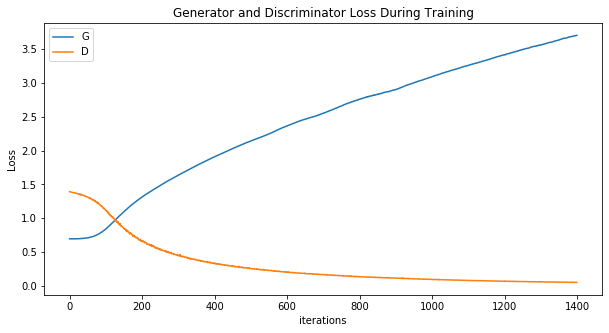

In [11]:
plot_train_loss()

# Animation

In [12]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

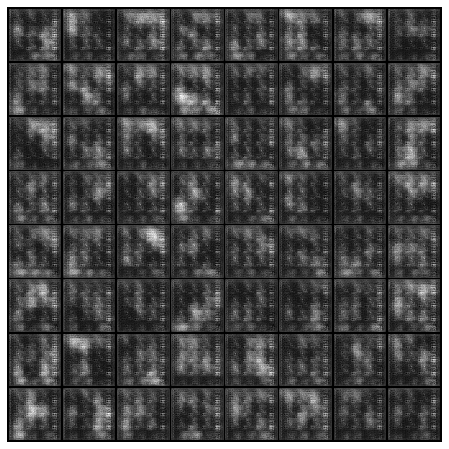

In [13]:
animate_gen_imgs()

# Anomaly Loss

In [15]:
latent_vector = torch.randn(1, latent_size, 1, 1, device = device, requires_grad=True)

def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    _, Test_Data_feature = D(Test_Data)
    _, G_Data_feature = D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

z_optimizer = torch.optim.Adam([latent_vector],lr=0.01,betas=(0.5, 0.999))


test_data_root = "../../../OhSeHyeon/source/dataset/test/test_DualPhaseSteel"
test_data_set = dataset.ImageFolder(root = test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))


# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# Train Latent Space Z

In [16]:
latent_space = []
auc=[]

def train_latent_space():
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data = G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step == 400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss > 500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [17]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 1302.3640  Sum_of_z : 5.1384
[200]	 Ano_loss : 1230.6055  Sum_of_z : -2.9915
[400]	 Ano_loss : 1225.2776  Sum_of_z : -3.9051
picture  2
[0]	 Ano_loss : 1215.9890  Sum_of_z : -3.7537
[200]	 Ano_loss : 1137.3700  Sum_of_z : -7.2874
[400]	 Ano_loss : 1135.1323  Sum_of_z : -9.1773
picture  3
[0]	 Ano_loss : 1163.6254  Sum_of_z : -9.3084
[200]	 Ano_loss : 1104.5519  Sum_of_z : -14.0977
[400]	 Ano_loss : 1102.0913  Sum_of_z : -17.7306
picture  4
[0]	 Ano_loss : 625.2051  Sum_of_z : -17.6593
[200]	 Ano_loss : 554.1835  Sum_of_z : -11.3885
[400]	 Ano_loss : 551.6013  Sum_of_z : -11.1164
picture  5
[0]	 Ano_loss : 1372.5093  Sum_of_z : -11.1764
[200]	 Ano_loss : 1351.6672  Sum_of_z : -18.7324
[400]	 Ano_loss : 1350.5911  Sum_of_z : -17.3755
picture  6
[0]	 Ano_loss : 431.9450  Sum_of_z : -17.4047
[200]	 Ano_loss : 415.4603  Sum_of_z : -15.4064
[400]	 Ano_loss : 409.4326  Sum_of_z : -11.7913
picture  7
[0]	 Ano_loss : 702.7285  Sum_of_z : -11.7799
[200]	 Ano_loss : 681

---

# 이상 픽셀 수 확인 함수

In [18]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# Similar Z , Ano_Score and Segementation


In [19]:
diff_cnts = []
diff_points = []
anomaly_imgs = []


def compare_imgs(real_img, generated_img, i, reverse=False, threshold=50):
    global anomaly_img
    
    score = Anomaly_loss(real_img, generated_img)
    score = round(score.item(), 2)
    
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    negative = np.zeros_like(real_img)
    
    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
    diff_img[diff_img <= threshold] = 0
    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)
    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)
    if auc[i] == 0:
        fig.suptitle(f'Normal - (anomaly score: {score:.4})')
    else :
        fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')

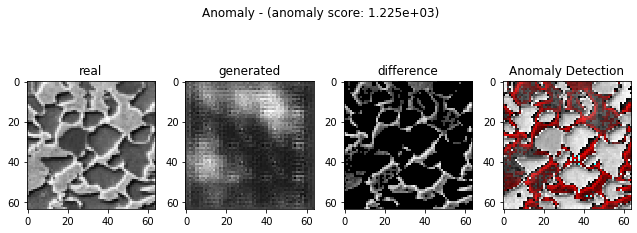

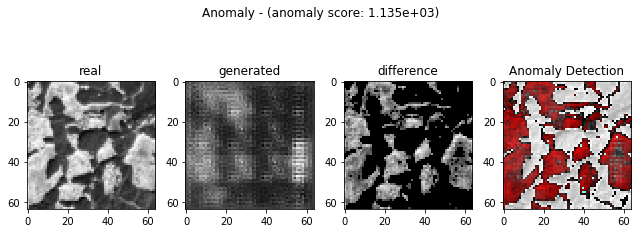

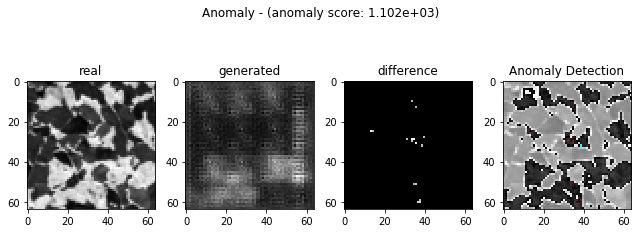

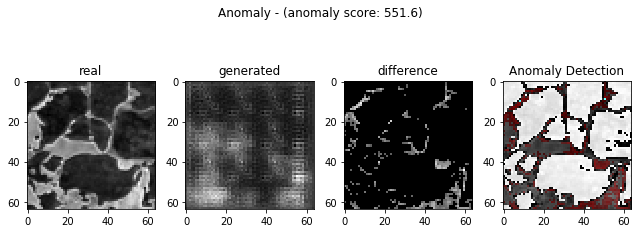

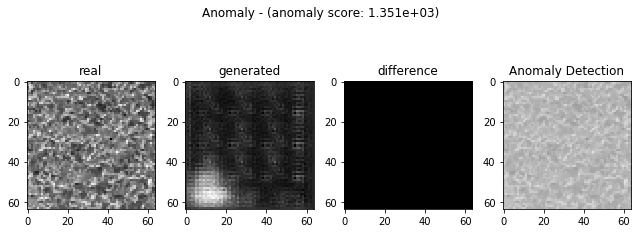

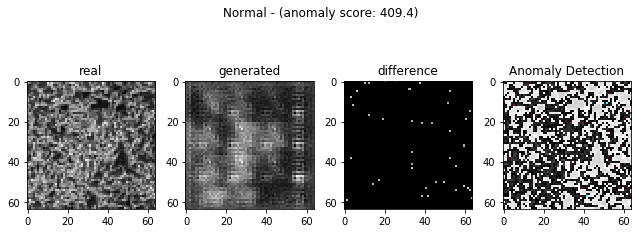

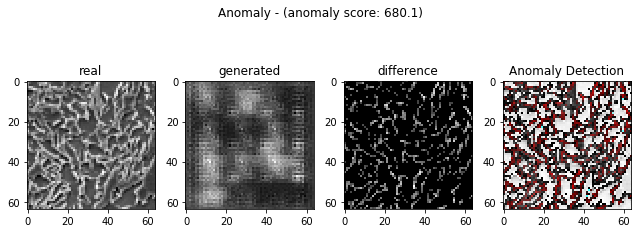

In [20]:
for i,data in enumerate(test_data_loader,0):
    test_img = data[0].to(device)

    #for i in range(len(latent_space)):
    update_z = latent_space[i]
    R_img = test_img
    G_img = G(update_z).to(device)
    
    if i in [9]:
        compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
    else:
        compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

---

# 분율 추출

In [21]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.33691406 0.42382812 0.00390625 0.11254883 0.         0.00952148
 0.20825195]


In [23]:
# 분율 평균
print(sum(diff_fraction)/len(diff_fraction))

0.15642438616071427


---

# 분산 추출

In [19]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)

In [20]:
cal_corr_coeffis()

print(corr_coeffis)

[0.041214619909023864, 0.0987833228312625, -0.2812151370256617, 0.20116074024258332, -inf, 0.01685872529293636, -0.08440814581309047]


---

# 모델 저장 및 읽기

In [21]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "G" : G.state_dict(),
        #"latent_space" : latent_space.state_dict(), # nn.model만 가지는 기능
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [22]:
save_pretrained()

In [23]:
pretrained_D = Discriminator().to(device)
pretrained_G = Generator().to(device)
#pretrained_latent_space = [] # 다시 학습해야 함

def load_pretrained():
    global pretrained_D
    global pretrained_G
    #global pretrained_latent_space
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_G.load_state_dict(pretrained["G"])
    #pretrained_latent_space.load_state_dict(pretrained["latent_space"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_G)
    #print("pretrained_latent_space :", pretrained_latent_space)

In [24]:
load_pretrained()

In [25]:
def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    
    _, Test_Data_feature = pretrained_D(Test_Data)
    _, G_Data_feature = pretrained_D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

In [26]:
# train latent_space

latent_space = []
auc = []

def train_latent_space():
    global latent_space
    global auc
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data   = pretrained_G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step==400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss>500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [27]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 1266.3403  Sum_of_z : -3.3242
[200]	 Ano_loss : 1264.7040  Sum_of_z : 0.9610
[400]	 Ano_loss : 1264.6361  Sum_of_z : 1.0947
picture  2
[0]	 Ano_loss : 1201.3168  Sum_of_z : 1.3532
[200]	 Ano_loss : 1199.7808  Sum_of_z : 11.9149
[400]	 Ano_loss : 1199.6984  Sum_of_z : 12.8498
picture  3
[0]	 Ano_loss : 1015.5364  Sum_of_z : 12.9203
[200]	 Ano_loss : 1013.7377  Sum_of_z : 6.7273
[400]	 Ano_loss : 1013.6226  Sum_of_z : -1.5176
picture  4
[0]	 Ano_loss : 524.4009  Sum_of_z : -1.5813
[200]	 Ano_loss : 523.0158  Sum_of_z : -6.6464
[400]	 Ano_loss : 522.9283  Sum_of_z : -4.0442
picture  5
[0]	 Ano_loss : 1090.5264  Sum_of_z : -4.1989
[200]	 Ano_loss : 1090.0314  Sum_of_z : -11.3059
[400]	 Ano_loss : 1090.0150  Sum_of_z : -12.8962
picture  6
[0]	 Ano_loss : 345.9109  Sum_of_z : -12.8769
[200]	 Ano_loss : 344.4709  Sum_of_z : 4.4213
[400]	 Ano_loss : 344.2828  Sum_of_z : 12.5208
picture  7
[0]	 Ano_loss : 671.7592  Sum_of_z : 12.4988
[200]	 Ano_loss : 670.0259  Sum_of

In [28]:
def test():
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)

        #for i in range(len(latent_space)):
        update_z = latent_space[i]
        R_img = test_img
        G_img = pretrained_G(update_z).to(device)

        if i in [9]:
            compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
        else:
            compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

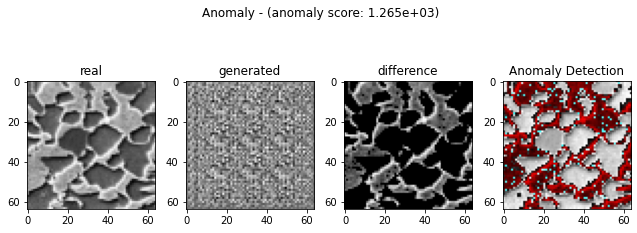

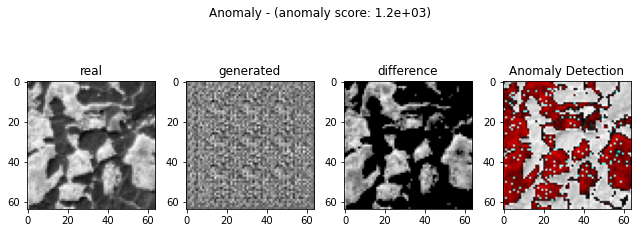

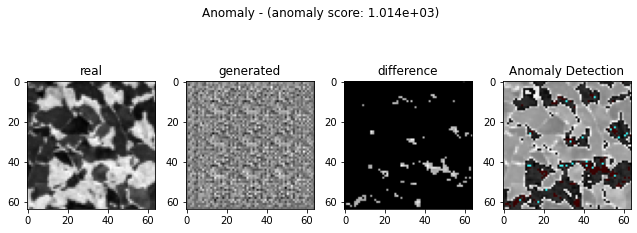

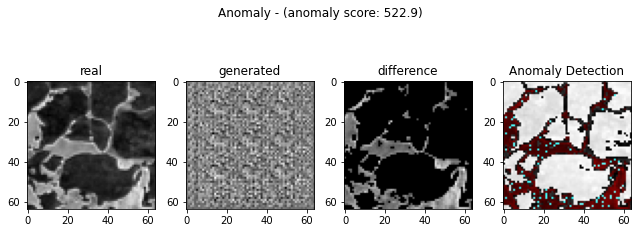

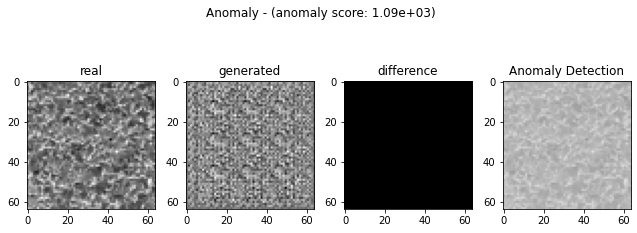

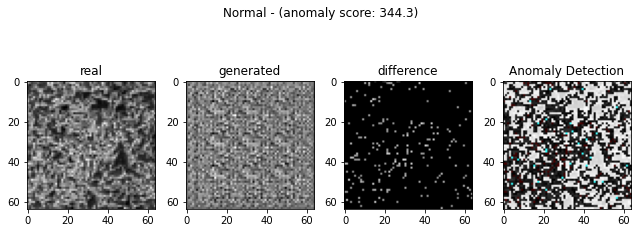

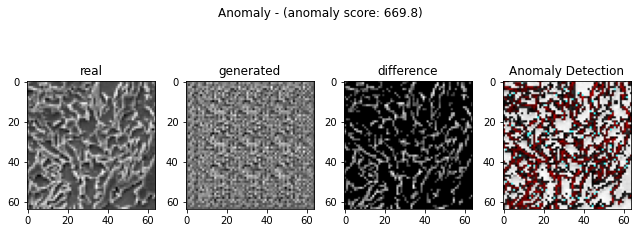

In [29]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [30]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.42578125 0.46264648 0.04516602 0.2355957  0.         0.04980469
 0.29760742]


In [31]:
cal_corr_coeffis()

print(corr_coeffis)

[0.03930323451955458, 0.09824271107967668, -0.28914111459826475, 0.19809595979534306, -inf, 0.04507935167666852, -0.08497257982755216]


---

# anomaly detection 이미지 추출

In [32]:
anomaly_imgs

[array([[[242, 242, 242],
         [246, 246, 246],
         [121,   0,   0],
         ...,
         [210, 210, 210],
         [176, 176, 176],
         [222, 222, 222]],
 
        [[248, 248, 248],
         [242, 242, 242],
         [ 87,   1,   1],
         ...,
         [238, 238, 238],
         [238, 238, 238],
         [190, 190, 190]],
 
        [[236, 236, 236],
         [230, 230, 230],
         [ 77,   3,   3],
         ...,
         [230, 230, 230],
         [232, 232, 232],
         [238, 238, 238]],
 
        ...,
 
        [[230, 230, 230],
         [248, 248, 248],
         [212, 212, 212],
         ...,
         [142, 142, 142],
         [ 85,  85,  85],
         [130, 130, 130]],
 
        [[228, 228, 228],
         [244, 244, 244],
         [230, 230, 230],
         ...,
         [105, 105, 105],
         [150, 150, 150],
         [252, 252, 252]],
 
        [[218, 218, 218],
         [228, 228, 228],
         [246, 246, 246],
         ...,
         [182, 182, 182],
  

# 이미지 저장 함수

In [33]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [34]:
save_imgs("./anomaly_imgs", anomaly_imgs)

image saving complete


---

# 티타늄(Ti64) 상대 밀도 계산

In [35]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

[1.88621094 2.04952393 0.20008545 1.04368896 0.         0.22063477
 1.31840088]
